In [2]:
import yfinance as yf

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [3]:
import os
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [4]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.055241,0.063365,0.055241,0.060657,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060657,0.063907,0.060657,0.062823,308160000,0.0,0.0
1986-03-17 05:00:00,0.062823,0.064448,0.062823,0.063907,133171200,0.0,0.0
1986-03-18 05:00:00,0.063907,0.064448,0.061740,0.062281,67766400,0.0,0.0
1986-03-19 05:00:00,0.062281,0.062823,0.060657,0.061198,47894400,0.0,0.0


<AxesSubplot:>

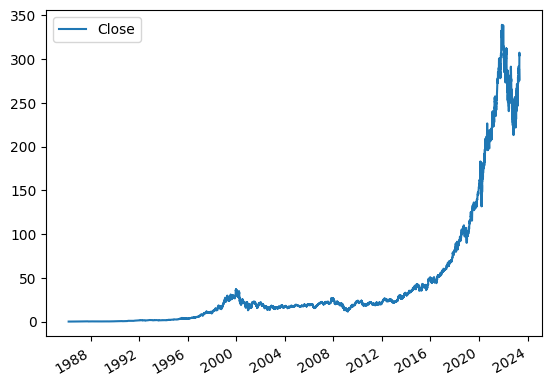

In [5]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [6]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [7]:
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [8]:
#Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [9]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062823,1.0,0.060657,1.031789e+09,0.055241,0.063365,0.055241
1986-03-17 05:00:00,0.063907,1.0,0.062823,3.081600e+08,0.060657,0.063907,0.060657
1986-03-18 05:00:00,0.062281,0.0,0.063907,1.331712e+08,0.062823,0.064448,0.062823
1986-03-19 05:00:00,0.061198,0.0,0.062281,6.776640e+07,0.063907,0.064448,0.061740
1986-03-20 05:00:00,0.059573,0.0,0.061198,4.789440e+07,0.062281,0.062823,0.060657


In [10]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
import numpy as np

# Create a random forest classification model
# Will compare w 2 models 

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1) #can use any classifier tbh 

model2 = AdaBoostClassifier(n_estimators=200, random_state=1) 

In [11]:
train = data.iloc[:-100]
test = data.iloc[-100:]


model.fit(train[predictors], train["Target"])
model2.fit(train[predictors], train['Target'])

AdaBoostClassifier(n_estimators=200, random_state=1)

In [12]:
#evaltime

from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
scores =  np.round(precision_score(test["Target"], preds), decimals=3)
print(f"Pure precision for r_forest = {scores}")


preds = model2.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
np.round(precision_score(test["Target"], preds), decimals=3)

print(f"Pure precision for Some random other classifier I googled= {scores}")




Pure precision for r_forest = 0.509
Pure precision for Some random other classifier I googled= 0.509


In [13]:
#Backtesting procedure:
# First 1k = training, next 750 = testing 


i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])